<span style="font-size: 15px;">ECO225 Project 1 2024 By Samuel Ahn</span>
<span style="font-size: 15px;">1009008967, ahnsamue, sam.ahn@mail.utoronto.ca</span>

# Project 1

## Introduction:

Real estate has consistently been a focal point of economic research since the beginning of the discipline. This is due to the unique position that these assets hold within a consumer’s life. A home is both a financial asset, increasingly the most important financial asset to its owner, and a physical space by which they call home. This unique combination of traits leads to an obvious but all-important outcome: financial means determines location of residence, which determines mobility. Being able to traverse comfortably, safely, and easily has been proven to have a positive impact on living standards and happiness (Kim E. and Kim H. 2020). This paper will aim to investigate the connections between real estate price and mobility. 
	
Given the importance of walkability on health, pollution, and community, several papers Investigating correlation between real estate value and walkability have been published in recent years (Pivo & Jeffery, 2011). Many of these papers rely on Ordinary Least Squares (OLS) regressions [(Kim E. & Kim H., 2020), (Gou et. al, 2017)], but this paper will serve to dig deeper, employing regressions, geospatial maps, and machine learning to fully understand the connections between variables. That being said, this paper lacks the ability to consider social aspects of property value (as in sentiment, design, or school quality), and thus will serve as an addition to the literature base that can be built upon with a more holistic review. 

This paper draws from real-estate data collected from Realtor.com, a real estate listing website, and contains over 1.4 million entries. This data will be supplemented with walkability data from the U.S. Census. These two datasets will allow analysis of correlation between price, walkability, and other real estate and mobility factors. This paper uses price as the dependent Y-variable, as it represents a comparable standard regardless of personal preference. The chosen X-variables and their reasoning are listed below:

‘bed’: Describes the number of bedrooms found within the property. Chosen as installing more bedrooms may cost money, increasing the cost of the home

‘bath’: Describes the number of bathrooms found within the property. Similar reasoning to bedrooms, as installing more bathrooms may cost money, increasing the cost of the home.

‘acre_lot’: Describes the lot size of the property in acres. Chosen due to the assumption that land costs money, thus as the size of a lot increases its value will follow. 

‘house_size’: Describes the square footage of the home. Chosen due to the assumption that as the size of a home increases, the price of building and thus also selling will follow. 

‘sold_before’: A dummy variable representing if the home was sold previously. Perhaps newer homes will have higher values than older homes. 

As stated before, this paper will aim to predict the price of homes, but as shown in later, the ‘price’ variable is highly skewed, and its values are very large. For this reason, and more justified later within the paper, the Y variable for this data is a new variable ‘log_price’, representing the log of the ‘price’ variable. 

This original dataset will be further supplemented via the EPA Smart Location Database from 2021. This dataset is published by the Environmental Protection Agency of the United States government, and is covered in more detail when it is merged into the original dataframe. 

Walkability, a tool which improves social welfare, shares a linear relationship with home price. Unlike other home characteristics, which hold exponential relationships with price, this means that walkability can increase by a much larger amount without significantly raising home price. This conclusion allows policy makers and developers alike to invest more heavily in walkable infrastructure without having too large an effect on home price. 

This paper also finds that this relationship holds in both urban and rural/suburban locations, meaning that these policy changes are not limited by demographic. 



### Literature Review

#### Defining Walkability:

While measurables are a definitive way to draw conclusions, relating the price of a home to the number of pedestrian crosswalks with 3 or more modes of transportation available within a 5 km radius is far less intuitive than using the term ‘walkability’. Planners utilize the term to describe a combination of factors, whether qualitative or quantitative, that is used to generate a level of comfort, safety, and usability of walking in a set area (Yencha, 2019). This focus by planners has drawn the attention of the government, who have now developed measures of walkability themselves (Chapman et. al, 2021). This paper will follow the definition of The National Walkability Index, developed by the U.S. Environmental Protection Agency to utilize in the census (Chapman et. al, 2021). The E.P.A. defines walkability through a combination of measurable factors gathered during the census, the specifics of which can be found in the user guide linked in the bibliography (Chapman et. al, 2021). 

#### Linking Walkability to Real Estate:

There are several methods for linking walkability to real estate prices. The most common is the hedonic price model. Several studies utilize this method, including [(Gou et. al, 2017), (Li et. al, 2015), (Rauterkus & Miller, 2011)]. This method allows for a prediction of real estate prices via walkability and other housing characteristics. This paper will focus more on investigation of the correlation itself, and at least in its current form will not attempt a hedonic model. 


## Data Cleaning/Loading:

In [30]:
#import libraries   
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydeck as pdk
import geopandas as gpd
import seaborn as sns
import requests
import warnings
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from IPython.display import display, HTML
from shapely.geometry import Point
from shapely import wkt
from bs4 import BeautifulSoup


%matplotlib inline

In [31]:
#read dataset and convert into a dataframe object
realtor= pd.read_csv("realtor-data.csv")
df=realtor.copy()
data_by_state = df.groupby('state')

The data has now been read into a dataframe object ‘df’, which will serve as the main dataframe for the remainder of the paper, and thus requires some additions. Here the dummy variable ‘sold_before’ is added, with value 0 representing a new home, and value 1 representing a home that has been previously owned. The variable ‘log_price’ is also added here, which will serve as the main Y-variable for this iteration of the paper. Included is a view of the first 5 rows of ‘df’, which confirms the two variables have been added successfully. This head also displays several variables not used during this iteration of the project. These variables include ‘city’,’zip_code’,and ‘status’. All three will be covered in further iterations of the project, and remain in the dataset for that reason. 

In addition, a grouped copy of ‘df’ has been created on the axis ‘state’. This dataframe will be used later in the paper. 


In [32]:
#Adding a dummy variable representing if a house has been sold before
df["sold_before"]=np.where(df.prev_sold_date.isnull(),0,1)
#creating new column in dataframe represinting log price values
df['price'] = df['price'].apply(lambda x: np.nan if x <= 0 else x)
df['log_price'] = np.log(df['price'])
#df.head()

Dataframe ‘df’ now has 12 columns (not including the index values), and 1401066 rows

## Summary Statistics Tables:

In [33]:
pd.options.display.float_format = '{:.2f}'.format
#printing summary statistics for numerical columns
def additional_stats(data_fr):
    additional_st ={
    'Mode': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].mode().iloc[0],
    'Variance': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].var(),
    'Skewness': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].skew(),
    'Kurtosis': data_fr[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].kurtosis()
    }
    return(additional_st)


summary_stats = pd.concat([df[['bed','bath','acre_lot','house_size','sold_before','price','log_price']].describe(), pd.DataFrame(additional_stats(df)).T])

print('Table 1: Summary Statistics of Data</div>')
display(summary_stats)

Table 1: Summary Statistics of Data</div>


,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1184538.00,1206853.00,1043599.00,950954.00,1401066.00,1400851.00,1400851.00
mean,3.39,2.49,32.15,2178.64,0.51,818665.42,12.97
std,2.05,1.87,1249.98,3492.62,0.50,2683161.76,1.09
min,1.00,1.00,0.00,4.00,0.00,1.00,0.00
25%,2.00,2.00,0.12,1170.00,0.00,235000.00,12.37
50%,3.00,2.00,0.32,1700.00,1.00,446900.00,13.01
75%,4.00,3.00,1.34,2500.00,1.00,795000.00,13.59
max,123.00,198.00,100000.00,1450112.00,1.00,875000000.00,20.59
Mode,3.00,2.00,0.06,1200.00,1.00,599000.00,13.30
Variance,4.21,3.51,1562457.18,12198380.78,0.25,7199357031184.68,1.18


Table 1 displays several interesting and important qualities of the data. Something immediately noticeable is the extreme skewness of every variable, but especially the price and house size variables. All variables are also extremely leptokurtic, signifying the possible presence of outliers. This point will be returned to before data-visualization begins, as the kurtosis is large enough to have a negative impact on readability of some figures and plots. The price variable has a variance of 7199357031184.68, a value so large that it would make essentially any graph involving the variable unreadable, thus we use log(price), which has a much more reasonable 1.18. In terms of values and in-context analysis, it is possible that these data include information about non-single family homes, as the max values of 123 bedrooms and 198 bathrooms hints towards multi-residential buildings. Another very interesting thing to notice is the extremely small median of 0.32 for acre_lot given its mean and standard deviation. This could be due to the large disparity in land access in urban vs. rural areas. It is rare to see an urban property with more than a small backyard, and common to see a rural home with acres of field or forest. The final important takeaway from these simple sample statistics is the amount of missing data. The variable with the most missing entries is house_size, followed closely by acre_lot. This may present itself as an issue in the future, and thus should be noted.

Due to these signs of extreme outliers, a new dataframe object will be created with said outliers removed. This dataframe will only be used for visualizations that are negatively impacted by the extreme outliers, and will be identified whenever it is used. The metric used to determine an extreme outlier within this dataset will be the interquartile range (IQR). The IQR method is used instead of z-scores due to the skewed distribution of the data. Because the goal of this action is to only remove truly extreme outliers, an 'extreme outlier' in this paper represents a datapoint with a value for any of the 6 variables presented in Table 1 (sans log_price) that is either below 4 IQRs from the 25th percentile, or above 4 IQRs from the 75th percentile. This prevents the removal of large amounts of data, and should have a minimal effect on the total number of entries.


In [34]:
pd.options.display.float_format = '{:.2f}'.format

#identifying which variables we would like to remove outliers for
columns_to_remove_outliers = {'bed','bath','acre_lot','price','house_size'}

#we create a version of our data without extreme outliers for plotting 
data = df.copy()

for column in columns_to_remove_outliers:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr = (df[column] < (Q1 - 4 * IQR)) | (df[column] > (Q3 + 4 * IQR))
    data = data.loc[~outliers_iqr]

#printing summary statistics for new cropped data
summary_stats_no_outliers = pd.concat([data[['bed','bath','acre_lot','house_size','sold_before','price',\
                                             'log_price']].describe(), pd.DataFrame(additional_stats(data)).T])

print('Table 2: Summary Statistics With Extreme Outliers Removed')
display(summary_stats_no_outliers)


Table 2: Summary Statistics With Extreme Outliers Removed


,bed,bath,acre_lot,house_size,sold_before,price,log_price
count,1084162.00,1106097.00,905578.00,859908.00,1236847.00,1236634.00,1236634.00
mean,3.25,2.29,0.74,1872.93,0.54,575997.04,12.88
std,1.59,1.14,1.14,1050.06,0.50,517660.25,0.96
min,1.00,1.00,0.00,4.00,0.00,1.00,0.00
25%,2.00,1.00,0.11,1134.00,0.00,235000.00,12.37
50%,3.00,2.00,0.25,1620.00,1.00,425000.00,12.96
75%,4.00,3.00,0.81,2341.00,1.00,729000.00,13.50
max,12.00,7.00,6.22,7816.00,1.00,3025000.00,14.92
Mode,3.00,2.00,0.06,1200.00,1.00,599000.00,13.30
Variance,2.52,1.29,1.30,1102636.19,0.25,267972133011.35,0.93


As shown in Table 2, removing the extreme outliers had a large effect on the skewness and kurtosis for all 5 variables. While all variables except for sold_before and log_price remain strongly right-skewed, the amount of skew has become far more reasonable for data visualizations. The data has also retained a very large number of entries, meaning that the 4 IQR range for classification was effective in keeping a vast majority of properties untouched. Interestingly, the removal of these outliers had small effects on most of the quantiles of all 5 variables, meaning that the outliers were indeed a small portion of the properties, and were only having a large impact on the standard deviations and means due to their extreme nature. 

The ultimate goal of this paper is to present data in a meaningful and understandable way, thus the improved clarity of certain figures was deemed worth this slight loss in data. 



## Plots, Histograms, Figures

The first important step that must be taken to understand the data is visualization of the key Y-variable, price. Here, both ‘price’ and ‘log_price’ are shown to display the differences, and justify the decision to use ‘log_price’ as the Y-variable.


Figure 1: Price versus Log Price Distribution


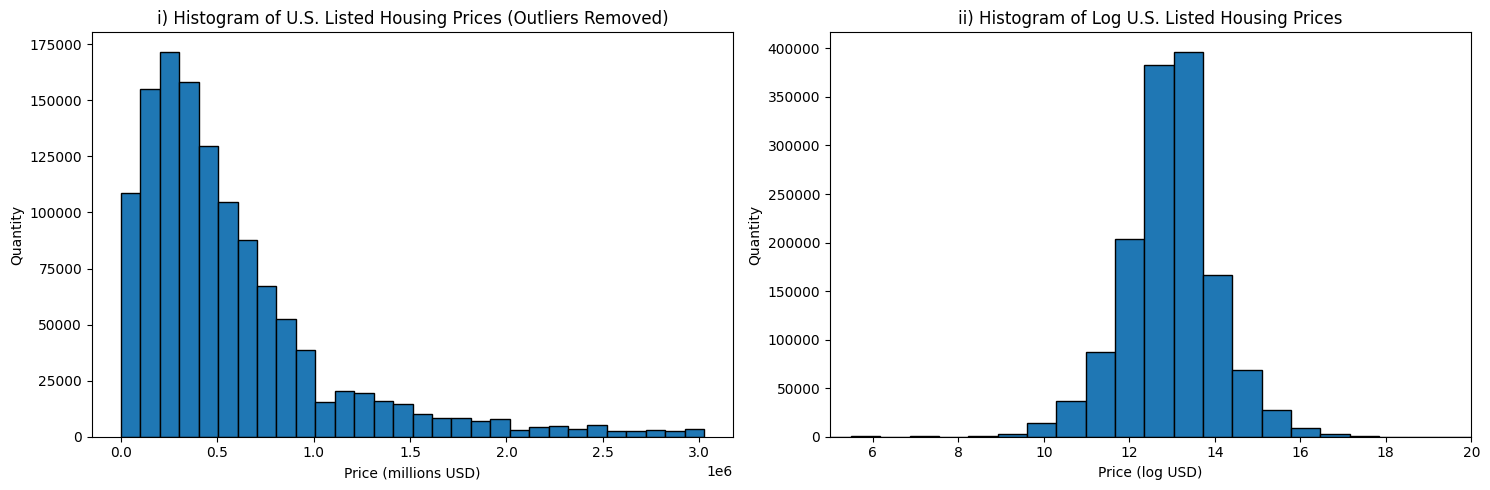

In [35]:
print('Figure 1: Price versus Log Price Distribution')

#Plotting data for price distribution
fig, fig_price = plt.subplots(1,2,figsize=(15,5))

fig_price[0].hist(data['price'],bins=30,edgecolor='black')
fig_price[0].set_title("i) Histogram of U.S. Listed Housing Prices (Outliers Removed)")
fig_price[0].set_ylabel("Quantity")
fig_price[0].set_xlabel("Price (millions USD)")

#Plotting data for log price distribution
fig_price[1].hist(df['log_price'],bins=30,edgecolor='black')
fig_price[1].set_title("ii) Histogram of Log U.S. Listed Housing Prices")
fig_price[1].set_ylabel("Quantity")
fig_price[1].set_xlabel("Price (log USD)")
fig_price[1].set_xlim(5,20)

plt.tight_layout()

Figure 1 is broken into two subfigures: 

F.1 i) depicts the distribution of variable ‘price’, clearly showing the positive skew identified within the summary statistics. This distribution is unimodal, with a clear peak at 250,000 USD. The distribution shows a clear change in slope at 1,000,000 USD, where the slope of the distribution decreases sharply. This is a point not seen in the ‘log_price’ data, and could become a point for grouping in the future. This distribution clearly shows the “bottom heavy” nature of the real estate market, where the majority of properties fall under the 1,000,000 USD mark. 

F.1 ii) presents as a unimodal, steep distribution with a peak of around 13. This is less intuitive than a value given by the ‘price’ distribution, but due to the symmetrical shape allows us to translate that the median of the data is around 440,000 USD, which matches the value we see in the summary statistics table. 

Both F.1 i) and F.1 ii) have their uses, but the distribution of only the Y-variable is insufficient to describe the entire dataset. 


Figure 2: Distribution of X-variables


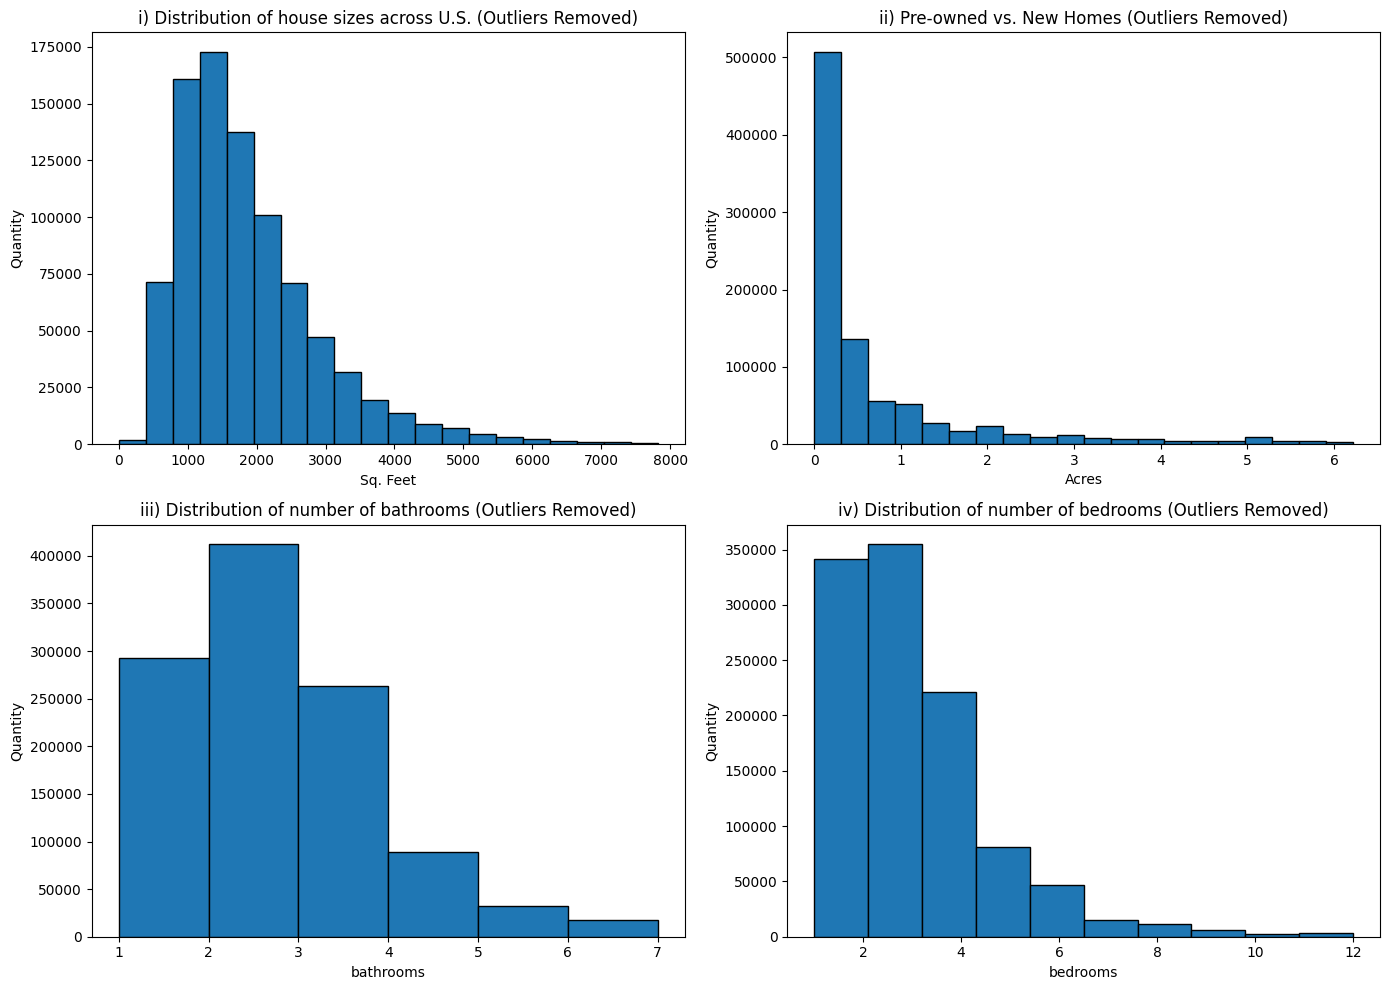

In [36]:
print('Figure 2: Distribution of X-variables')

def set_label(ax, title, x, y, a, b):
    ax[a,b].set_title(title)
    ax[a,b].set_xlabel(x)
    ax[a,b].set_ylabel(y)

fig, fig_1 = plt.subplots(2, 2, figsize=(14, 10))

fig_1[0,0].hist(data['house_size'], bins=20, edgecolor="black")
set_label(fig_1,'i) Distribution of house sizes across U.S. (Outliers Removed)','Sq. Feet','Quantity',0,0)

fig_1[0,1].hist(data['acre_lot'], bins=20, edgecolor='black')
set_label(fig_1,'ii) Pre-owned vs. New Homes (Outliers Removed)','Acres','Quantity',0,1)

fig_1[1,0].hist(data['bath'], bins=6, edgecolor="black")
set_label(fig_1,'iii) Distribution of number of bathrooms (Outliers Removed)','bathrooms','Quantity',1,0)

fig_1[1,1].hist(data['bed'], bins=10, edgecolor="black")
set_label(fig_1,'iv) Distribution of number of bedrooms (Outliers Removed)','bedrooms','Quantity',1,1)

plt.tight_layout()

Figure 2 again presents several subplots:

F.2 i) Shows the distribution of variable ‘house_size’. This distribution is similar to the house price distribution, hinting at a possible close correlation. Both unimodal and positively skewed, the most interesting finding being that very few homes are under 500 square feet. These homes typically represent studio apartments or sublet rooms, and are a lifeline for low-income consumers. The severe lack of these “micro-residences” may not be replicated in other countries, as the U.S. has traditionally strayed away from constructing properties of this nature. 

F.2 ii) Shows the distribution of the ‘acre_lot’ variable. This distribution shows visually the stark difference in property size between properties that was touched upon during analysis of the summary statistics. With the vast majority of homes holding less than 1 acre, the few properties holding large amounts of land, most of which are not pictured due to the removal of outliers, hold most of the land in the real estate market. 

F.2 iii) & F.2 iv) depict the distributions of the number of bathrooms and bedrooms respectively, and both share similar information. Both are unimodal and positively skewed, similar to all of the other distributions. The one difference between the two is the fact that homes tend to have less bathrooms than they do bedrooms. 

The fact that all four distributions look similar to each other and to the price distribution gives a hint at the possible correlation between each of them with the price variable. This is important for further research as having a strong correlation between these X-variables and the Y-variable will allow for easier isolation of the effects of walkability or other mobility data. The only X-variable not covered in these distributions is the ‘sold_before’ dummy variable, which will be better displayed in a pie chart. 


Figure 3: Distribution of Houses by Sold Before Status


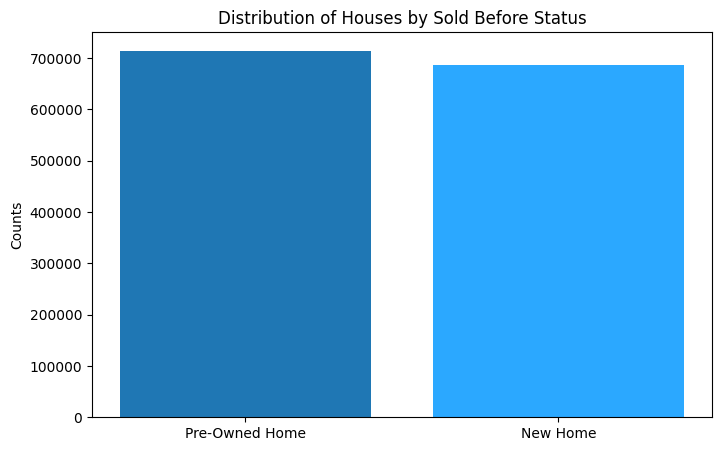

In [37]:
print('Figure 3: Distribution of Houses by Sold Before Status')
sold_counts = df['sold_before'].value_counts()

labels = ['Pre-Owned Home', 'New Home']
colors = ['#1f77b4', '#2ba8ff']

fig, ax = plt.subplots(figsize=(8, 5))
# Create bar plot
ax.bar(labels, sold_counts, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Distribution of Houses by Sold Before Status')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

plt.show()

Figure 3 clearly shows that while there are slightly more pre-owned homes than new homes, each represents essentially half of the data. This is good news for further research, as it means there is an abundance of data for both values of ‘sold_before’, allowing for conclusive results if they happen to present different trends when grouped separately. In combination with location and walkability data this would allow the ability to see if new developments were better or worse for walkability than their older counterparts, and where walkable developments are being constructed. 


Figure 4: Number of Entries for Each State</div>


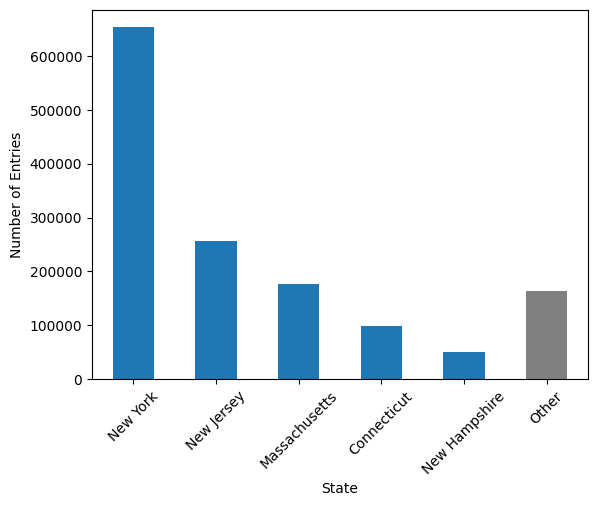

In [38]:
print('Figure 4: Number of Entries for Each State</div>')
data_by_state_vals = df['state'].value_counts()

top_5_states = data_by_state_vals.head(5)
other_states_sum = data_by_state_vals[5:].sum()

colors_bar = ['#1f77b4','#1f77b4','#1f77b4','#1f77b4','#1f77b4','Grey']

# Using pd.concat instead of append
top_5_and_other = pd.concat([top_5_states, pd.Series([other_states_sum], index=['Other'])])

# Plot
top_5_and_other.plot(kind='bar',color=colors_bar)
plt.xlabel('State')
plt.ylabel('Number of Entries')
plt.xticks(rotation=45)  # Rotate state names for better readability
plt.show()

Figure 4 shows a bar plot representing the quantity of data for each state within ‘df’. As shown, New York represents a large portion of the data, followed by New Jersey and Massachusetts. This has major implications for conclusions drawn by the paper. These states all represent the North-Eastern United States, and while that alone does not present a problem, it limits this paper’s ability to draw conclusions about the entire U.S., as the northeast differs drastically from the west coast or the south. The northeast also represents some of the wealthier areas of the U.S. meaning that our data and findings may be skewed towards the higher end of the price bracket. Although, because the northeastern states share many qualities, there might be stronger conclusions when only applying to the northeast. 

After finally establishing the dataset, it is time for initial mapping of X-variables to the Y-variable. This initial stage will not be conducted on variable ‘sold_before’ as its nature as a dummy variable prevents transferrable conclusions in the same way as the other X-variables. That is not to say that it cannot predict the Y-variable, just that it will be covered in further research.


Figure 5: Price Responses to X-Variables


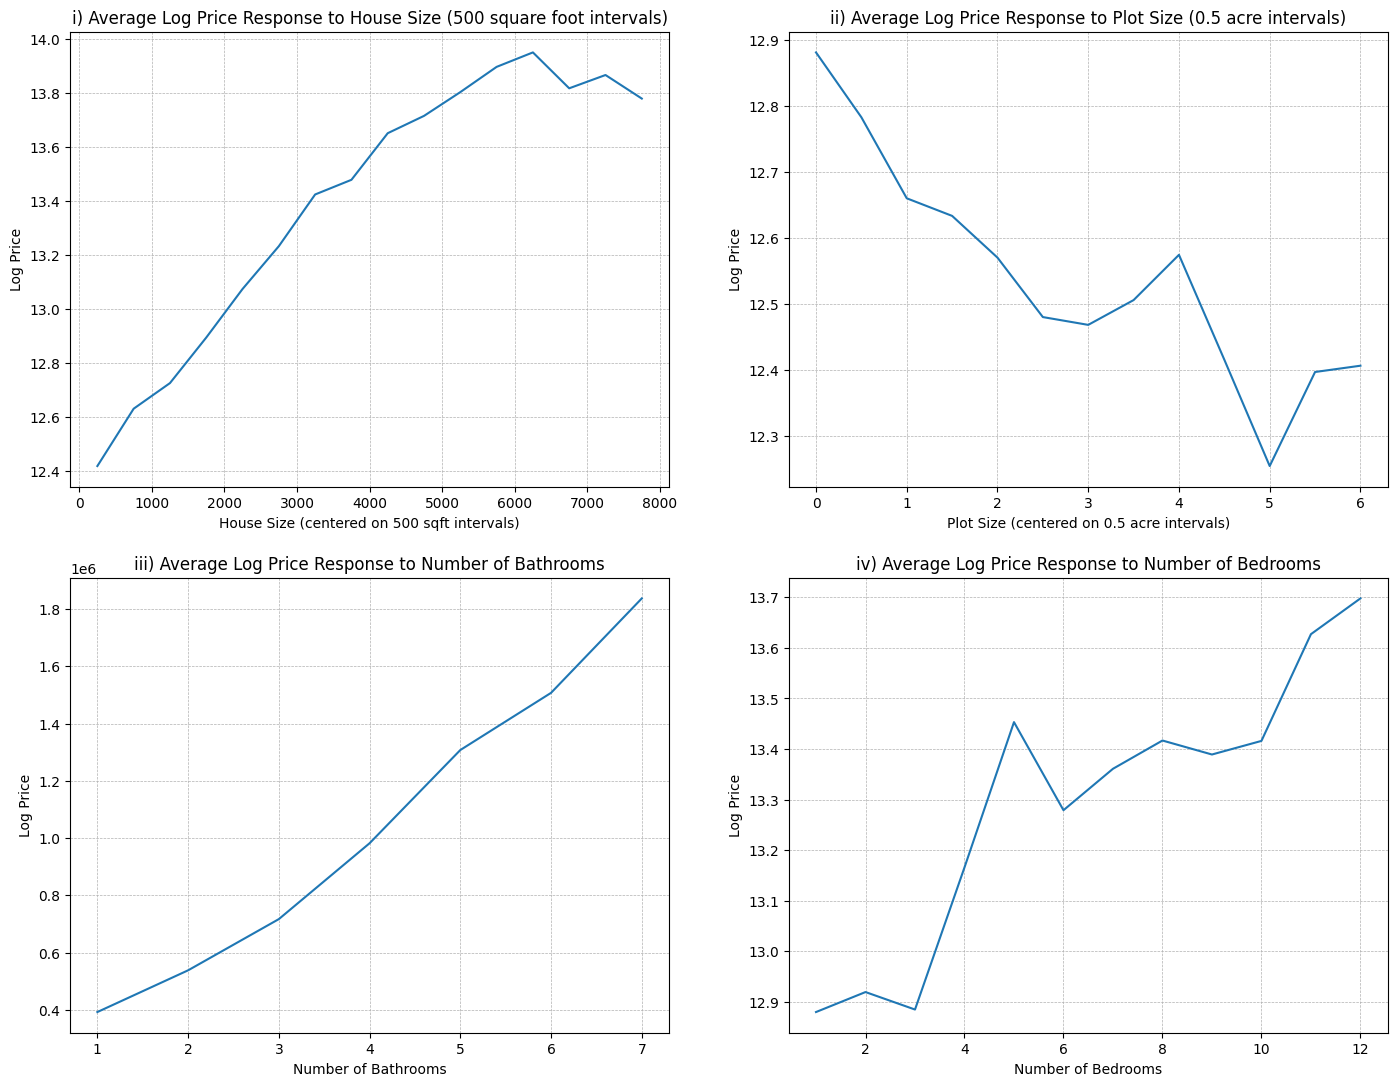

In [39]:
print('Figure 5: Price Responses to X-Variables')

data['house_size_interval'] = (data['house_size'] // 500) * 500 + 250
data['acre_interval'] = (data['acre_lot'] // 0.5) /2

# Initialize the figure
fig, ax = plt.subplots(2,2,figsize=(17, 13))

# Plot the average price for the entire dataset
overall_averages = data.groupby('house_size_interval')['log_price'].mean().reset_index()
ax[0,0].plot(overall_averages['house_size_interval'], overall_averages['log_price'], label='Overall')
set_label(ax,'i) Average Log Price Response to House Size (500 square foot intervals)',\
          'House Size (centered on 500 sqft intervals)','Log Price',0,0)
ax[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_acre = data.groupby('acre_interval')['log_price'].mean().reset_index()
ax[0,1].plot(overall_averages_acre['acre_interval'], overall_averages_acre['log_price'], label='Overall')
set_label(ax,'ii) Average Log Price Response to Plot Size (0.5 acre intervals)',\
          'Plot Size (centered on 0.5 acre intervals)','Log Price',0,1)
ax[0,1].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bath = data.groupby('bath')['price'].mean().reset_index()
ax[1,0].plot(overall_averages_bath['bath'], overall_averages_bath['price'], label='Overall')
set_label(ax,'iii) Average Log Price Response to Number of Bathrooms','Number of Bathrooms','Log Price',1,0)
ax[1,0].grid(True, which='both', linestyle='--', linewidth=0.5)

overall_averages_bed = data.groupby('bed')['log_price'].mean().reset_index()
ax[1,1].plot(overall_averages_bed['bed'], overall_averages_bed['log_price'], label='Overall')
set_label(ax,'iv) Average Log Price Response to Number of Bedrooms','Number of Bedrooms','Log Price',1,1)
ax[1,1].grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

Figure 5 depicts 4 subplots, all of which show the average ‘log_price’ with respect to the X variable:

F.5 i) depicts the average ‘log_price’ response to each 500 square foot jump in ‘house_size’. This plot informs of the positive, weakly-linear relationship between house size and price. On average, the log price of a home increases rather consistently with an increase in home size. This conclusion is not surprising, as in the assumptions made when choosing house size as an X-variable, an increase in house size will cost money to build, increasing the sale price of the home. In terms of further research, this tells us that house size will be a strong predictor of home value.

F.5 ii) shows the average ‘log_price’ response to each 0.5 acre jump in ‘acre_lot’. This figure greatly contradicts the assumption made when acre_lot was chosen as an X-variable. As the plot size of a property increases, the value of the property actually decreases. This finding is so unintuitive that it is almost certainly linked to other factors. A possible explanation of this confusing finding can be drawn from the information from F.2 ii), that the vast majority of homes lie under the one acre mark. While the downward trend continues in this range, it makes sense that if the majority of properties lie within this group, there is a large chance that includes many high-value properties. This remains a highly interesting finding that will need to be both discussed and investigated further in future research. 

F.5 iii) depicts the average ‘log_price’ response to an increase in ‘bath’. This subfigure shows the closest to a linear correlation, with a slight decrease in slope after 5 bathrooms. Bathrooms are a necessity in every home, regardless of preference, and thus it reasons that a more expensive home will have more bathrooms. F.5 iii)’s findings almost perfectly match the assumption made when ‘bath’ was picked as an X-variable. In terms of future research, it may be interesting to view the importance of more bathrooms in an urban vs rural location, as perhaps more space-conscious urban residents value bathrooms differently than their rural counterparts. 

F.5 iv) represents the average ‘log_price’ response to an increase in ‘bed’. This subfigure has a very interesting shape compared to F.5 iii), contrary to the distributions which shared very similar qualities. F.5 iv) shows very sharp changes in average price for homes with different numbers of bedrooms, with the marginal value of an extra bedroom skyrocketing from 3 to 5. The strange changes in marginal log price presents an avenue for future research and discussion. Perhaps 5 bedrooms is the reasonable limit for urban residences?


# Project 2

## Merging With Another Dataset

While currently this dataset provides an immense amount of real-estate characteristics, it lacks the key variable required for the remainder of this paper: a walkability index. When deciding which walkability index to utilize, the U.S. Environmental Protection Agency (EPA)’s Smart Location Database was used. This database provides several benefits over other walkability indexes:

1. It is a public resource, allowing further research and ease of access
2. It has data down to the census block group level, allowing for precise conclusions
3. It is updated with every census, and thus presents the opportunity for analysis of change over time in the future

That being said, the combining with the Smart Location Database also has some flaws:

1. The census block groups do not perfectly match with the zip codes given in the original dataset
2. With the mapping level being quite high (zctas), mapping individual data points will not be effective at displaying general trends

This first code cell attempts to deal with problem number 1. 


In [40]:
#turning zips in realtor data into real zips
df_no_missing = df[df['zip_code'].notna()].copy()
df_no_missing['zip_code'] = df_no_missing['zip_code'].astype(int).astype(str).str.zfill(5)

#reading in the converter
zip_to_zcta_df = pd.read_csv("zip_zcta_xref.csv", dtype={'zip_code': str,'zcta': str})
z_z = zip_to_zcta_df.drop('source', axis = 'columns')
z_z['zip_code'] = z_z['zip_code'].astype(str)
z_z['zcta'] = z_z['zcta'].astype(str)

df_no_missing['zip_code'] = df_no_missing['zip_code'].str.strip()
z_z['zip_code'] = z_z['zip_code'].str.strip()

#adding zctas to dataset
df_z = pd.merge(df_no_missing,z_z,on = 'zip_code',how = 'left')
#df_z.head()

Table 3 displays the new dataset, utilizing zip_zcta_xref.csf (@JoeGermuska on GitHub), a crosswalk between USPS zip codes and Zip Code Tract Areas (ZCTAs). ZCTAs are a census group that allows zip codes to be used to analyze data on a nationwide scale. For the use of this project, the ZCTAs will allow for merging with the necessary walkability data. 

Each ZCTA is a 5 digit numerical string, often being exactly the same as the USPS postal code, and will be used for mapping later in the project. 


In [41]:
c_to_avg = ['bed','bath','acre_lot','house_size','sold_before','price','log_price','zcta']
d_selected = df_z[c_to_avg]

df_zcta_avg = d_selected.groupby('zcta').mean()
df_zcta_avg.reset_index(inplace=True)
#df_zcta_avg.head()

Now that the ZCTAs have been added to the dataframe, the second problem must be addressed. With so many data points, creating a map of all points will be messy and non-useful, thus, a new dataframe is created specifically for mapping named df_zcta_avg. This dataframe will be created by grouping the newly edited dataframe by ZCTAs, and then calculating the aggregate means for each column in each group. Then the index will be reset. This gives us a new dataframe with the average home characteristics within each ZCTA, a very useful tool for mapping. 

In [42]:
walkability = pd.read_csv("EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv", dtype={'COUNTYFP': str,'TRACTCE': str,'BLKGRPCE': str})
zcta_block = pd.read_csv('tab20_zcta520_tabblock20_natl.txt', sep = '|', header = 0, usecols=['GEOID_ZCTA5_20', 'GEOID_TABBLOCK_20'], dtype=str)

# Rename columns in the converter to match those in df for a consistent merge
zcta_block.rename(columns={'GEOID_ZCTA5_20': 'zcta','GEOID_TABBLOCK_20': 'block_group'}, inplace=True)
zcta_block.dropna(subset=['zcta'], inplace = True)
zcta_block['block_group'] = zcta_block['block_group'].str[:12]

def most_common_block_group(series):
    return series.mode()[0] 

# Group by 'zcta', and aggregate 'block_group' using the custom function
agg_df = zcta_block.groupby('zcta').agg({'block_group': most_common_block_group}).reset_index()

# Merge the DataFrames on 'zcta'
merged_df = pd.merge(df_zcta_avg, agg_df, on=['zcta'], how='left')
#merged_df.head()

#Prepare the walkability DataFrame by creating a FIPS code
walkability['block_group'] = walkability['STATEFP'].astype(str).str.zfill(2) + walkability['COUNTYFP'].astype(str).str.zfill(3) + walkability['TRACTCE'].astype(str).str.zfill(6) + walkability['BLKGRPCE'].astype(str)
walkability['block_group'] = walkability['block_group'].astype('Int64').astype(str)

conditions = [(walkability['D1B'] > 5)]
choices = ['Urban']

walkability['area_type'] = np.select(conditions, choices, default='Rural')

#Merge the new df with the walkability score based on TRACT
final_df = pd.merge(merged_df, walkability[['block_group', 'NatWalkInd','area_type', 'D3AAO', 'D1B', 'D5AR', 'TotEmp','Pct_AO0']], on='block_group', how='left')


#adding Walkscore back to the original df
df_z = df_z.merge(final_df[['zcta', 'NatWalkInd','area_type', 'D3AAO', 'D1B', 'D5AR', 'TotEmp','Pct_AO0']], on='zcta', how='left')

Once that aggregate data frame is created, the walkability data will be merged into the dataset. The walkability dataset only includes Census Block Groups as region parameters, and thus the relationship file taken from the U.S. Census website is used to convert ZCTAs into Census Block Groups to allow for merging.
	
This method inherently has some flaws, as ZCTAs are distinct from Census Block Groups, and thus some areas of overlap will be missing inherently. This presents an opportunity for further research, as a real-estate dataset that includes direct census measurement tools would allow for a more accurate picture of the real world. For now, this flawed method will have to do, as it is the only way to connect the walkability data to the real estate data. 

The final dataframe needed for mapping has 16 columns, and is now ready for mapping (ignoring shapefiles). This table displays the average characteristics of a home in each ZCTA, importantly, including walkability. A new column was also added, area_type, which is either “Rural” or “Urban”, and was categorized based on the U.S. Census definition of a population of over 5000 or over 2000 housing units. Note, the new dataframe we have created was merged onto our original data, so many of the census ZCTAs available in the Smart Location Database are now missing in maps that will be presented later. This is done to be consistent in presented information.

Now that a complete dataset has been created, a deep dive into the data is possible. 


## The Message

### THE MESSAGE ITSELF:
This paper shows that whether in an urban or rural/suburban community, walkability has an essentially linear relationship with home price, unlike the exponential relationships of other home characteristics. This means, assuming utility gain from walkability, something proven in other papers that this paper assumes, homeowner utility can be greatly increased at a far lower cost than other home characteristics. 


### Justification:

Figure 6: Average Log Price by Walkability Bin


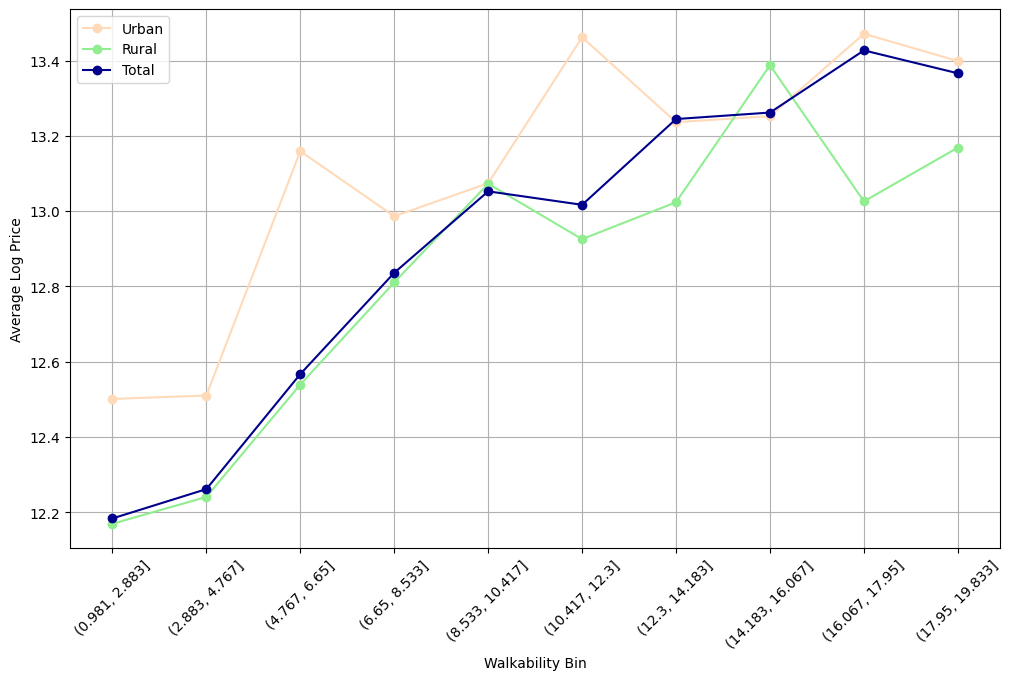

In [43]:
print('Figure 6: Average Log Price by Walkability Bin')
df_urb = df_z[df_z['area_type'] == 'Urban'].copy()
df_sub = df_z[df_z['area_type'] != 'Urban'].copy()
df_z['walkability_bin'] = pd.cut(df_z['NatWalkInd'], bins=10)

df_urb['walkability_bin'] = pd.cut(df_urb['NatWalkInd'], bins=10)
df_sub['walkability_bin'] = pd.cut(df_sub['NatWalkInd'], bins=10)

# Calculate the average log price for each bin for urban and rural
avg_log_price_per_bin = df_z.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()
avg_log_price_per_bin_urban = df_urb.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()
avg_log_price_per_bin_rural = df_sub.groupby('walkability_bin', observed=True)['log_price'].mean().reset_index()

plt.figure(figsize=(12, 7))

# Urban line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin_urban['log_price'], marker='o', linestyle='-', color='peachpuff', label='Urban')

# Rural line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin_rural['log_price'], marker='o', linestyle='-', color='lightgreen', label='Rural')

# Total line
plt.plot(avg_log_price_per_bin['walkability_bin'].astype(str), avg_log_price_per_bin['log_price'], marker='o', linestyle='-', color='darkblue', label='Total')

plt.xlabel('Walkability Bin')
plt.ylabel('Average Log Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()  # This adds the legend to the plot

plt.show()

Improvements to walkable infrastructure have, in recent times, been wholly focused on urban areas. This follows from the assumption that those who live in urban cores care more about walkability, and that urban areas are often already somewhat walkable. This paper argues that this goes against the data. When plotted earlier in the paper, housing characteristics like number of bathrooms and bedrooms presented a linear correlation with log_price, meaning an exponential correlation with price. Figure 6 shows that walkability is unique in the fact that it displays a diminishing positive correlation with log price, meaning it holds a roughly linear correlation with home price. 

The reason this linear relationship is interesting is due to three things: 

1. People are willing to pay a premium for homes that are located in more walkable neighborhoods, but isolating that effect to just walkability may be hard
2. Unlike bedrooms or bathrooms, walkability is a ‘shared’ characteristic of a home, meaning that the cost of walkability is spread out among all those who live in a walkable neighborhood
3. People can live in very walkable societies without having to have drastic increases in the price of their home. 


The home often represents the single largest purchase of many Americans lives, and often makes up a significant portion of its owner’s financial assets, thus any factor able to change the amount one is willing to pay for a home is vital to understand. If walkability is a factor that can greatly increase the quality of one’s life, a statistic proven by many papers in the health and planning fields, and it can do so without having a severe impact on the price of one’s home, it presents an amazing opportunity for increased social utility without forcing home prices too high. Another insight of figure 6 is that both the urban and rural lines closely resemble the total line, meaning that these conclusions hold true for both urban environments, where most walkable infrastructure projects are currently being created, and rural environments, which are in dire need of walkable neighborhoods. 
Something to notice about Figure 6 is that the line for rural areas is slightly steeper than for urban areas. This is a very interesting finding, and will be elaborated on in future iterations of this project. 
Now that a relationship has been established between walkability and log price, we can visualize these relationships through mapping. 



## Maps and Interpretations

Figure 7: New York City Log Price and Walkability Index Maps


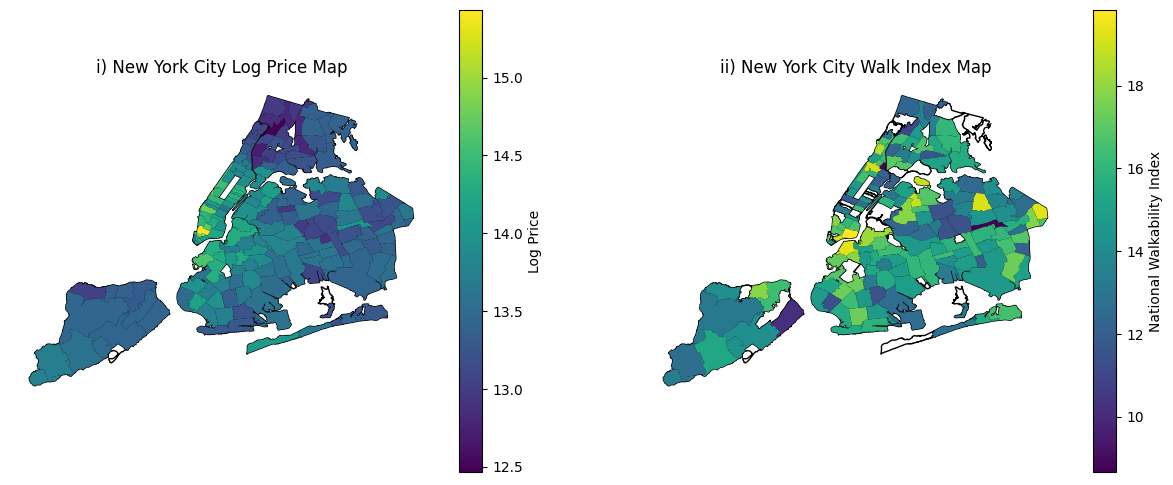

In [44]:
print('Figure 7: New York City Log Price and Walkability Index Maps')
nyc_df = pd.read_csv('Modified_Zip_Code_Tabulation_Areas__MODZCTA__20240229.csv', dtype = {'MODZCTA': str})
nyc_df.rename(columns={'the_geom': 'geometry', 'MODZCTA': 'zcta'}, inplace=True)
nyc_df['geometry'] = nyc_df['geometry'].apply(wkt.loads)
nyc_df = gpd.GeoDataFrame(nyc_df, geometry='geometry')

nyc_df_1 = pd.merge(nyc_df,merged_df,on = 'zcta', how = 'left')
nyc_df_2 = pd.merge(nyc_df,final_df,on = 'zcta', how = 'left')

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1
nyc_df.plot(ax=ax[0], color='white', edgecolor='black')
nyc_df_1.plot(column='log_price', ax=ax[0], legend=False, cmap='viridis')
ax[0].set_title("i) New York City Log Price Map")
ax[0].axis('off')

# Create a colorbar for the first plot
sm = ScalarMappable(norm=Normalize(vmin=nyc_df_1['log_price'].min(), vmax=nyc_df_1['log_price'].max()), cmap='viridis')
sm._A = []  # This is a workaround for missing array attribute error
cbar = fig.colorbar(sm, ax=ax[0])
cbar.set_label('Log Price')

# Plot 2
nyc_df.plot(ax=ax[1], color='white', edgecolor='black')
nyc_df_2.plot(column='NatWalkInd', ax=ax[1], legend=False, cmap='viridis')
ax[1].set_title("ii) New York City Walk Index Map")
ax[1].axis('off')

# Create a colorbar for the second plot
sm = ScalarMappable(norm=Normalize(vmin=nyc_df_2['NatWalkInd'].min(), vmax=nyc_df_2['NatWalkInd'].max()), cmap='viridis')
sm._A = []  # This is a workaround for missing array attribute error
cbar = fig.colorbar(sm, ax=ax[1])
cbar.set_label('National Walkability Index')

plt.show()

F.7 i) displays the distribution of home prices in New York City. We can clearly see that New York has very expensive real estate, as much of the entire city is more expensive than the mean log(price) of 12.8 found in the data. This map also depicts clear zones of higher costs. The close you get to Manhattan, and the center of the city, the more expensive the homes become. 

F.7 ii) shows a similar trend to home prices, with much of the city being far above the mean walkability score. This plot also shows an increase in walkability the closer you get to Manhattan, visually depicting the correlation that was covered in the “Main Message” section. 

These two plots together allow the visualization of the correlation between walkability and log price. This reaffirms the conclusions drawn by Figure 6, and further demonstrates the increased demand that comes with walkability. Given that New York City serves as an outlier in both price and walkability numbers, it is reasonable to question its efficacy as a measure of their relationship, but drawing back to the conclusions of Figure 6, this relationship should hold regardless of urban vs rural setting.

This map also reveals another interesting conclusion, which is areas of New York City that may have undervalued real estate. Given the particular city in question this is unlikely, but there are several ZCTAs with very high walk scores and only slightly above average price. 

Given the relationship between log(price) and walkability has been displayed, the paper will now turn back to the urban vs rural distinction.


Figure 8: New York State Urban vs Rural Division


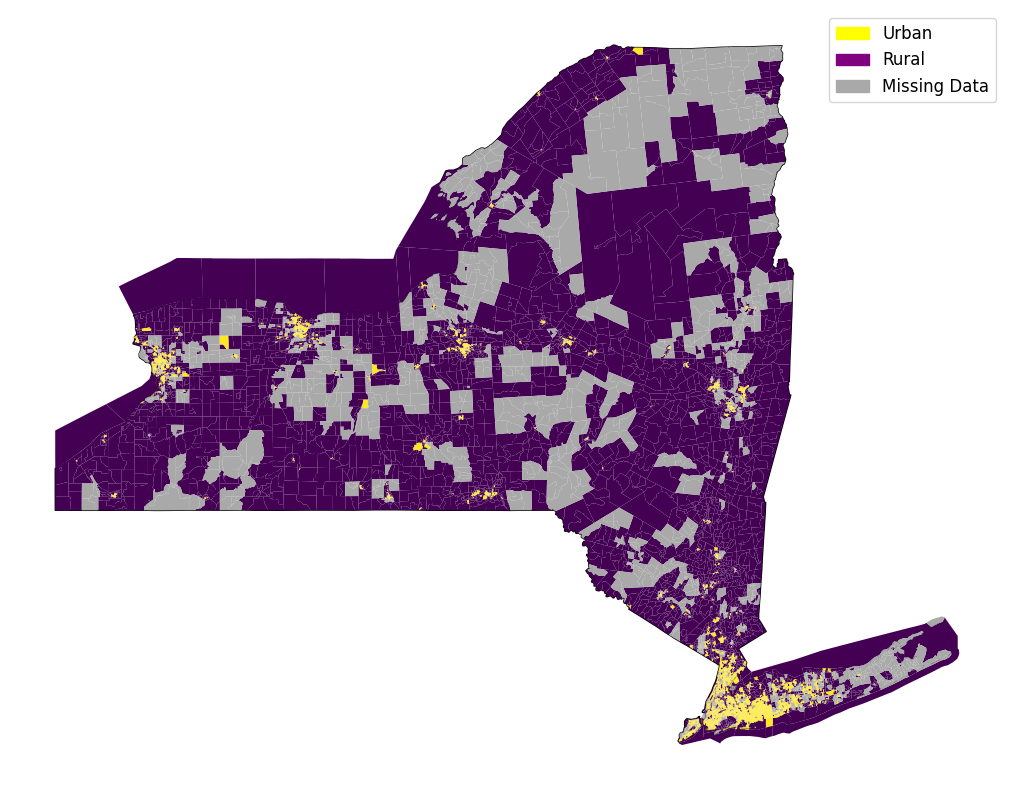

In [45]:
print('Figure 8: New York State Urban vs Rural Division')
ny_bg = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2021/BG/tl_2021_36_bg.zip", dtype={'COUNTYFP': str,'TRACTCE': str,'BLKGRPCE': str})

conditions = [(walkability['area_type'] == 'Urban')]
choices = [1]

walkability['a_type_num'] = np.select(conditions, choices, default=0)

state_df = gpd.read_file("http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_state_5m.zip")

ny_bg['block_group'] = ny_bg['STATEFP'].astype(str).str.zfill(2) + ny_bg['COUNTYFP'].astype(str).str.zfill(3) + ny_bg['TRACTCE'].astype(str).str.zfill(6) + ny_bg['BLKGRPCE'].astype(str)
ny_bg['block_group'] = ny_bg['block_group'].astype('Int64').astype(str)

merged_df_3 = pd.merge(ny_bg, walkability, on='block_group', how='left')

fig, gax = plt.subplots(figsize=(15, 10))

state_df[state_df["NAME"] == "New York"].plot(ax=gax, color="white", edgecolor="black")
merged_df_3.plot(ax=gax, column='a_type_num', legend=False, cmap='viridis', vmin=merged_df_3['a_type_num'].min(), vmax=merged_df_3['a_type_num'].max(), missing_kwds={'color': 'darkgrey', 'label': 'Missing values'})

urban_patch = mpatches.Patch(color='yellow', label='Urban')
rural_patch = mpatches.Patch(color='purple', label='Rural')
missing_patch = mpatches.Patch(color='darkgrey', label='Missing Data')
plt.legend(handles=[urban_patch, rural_patch, missing_patch], fontsize = 12)

plt.axis('off')
plt.show()

Figure 8 serves as a demonstration of urban vs suburban areas used in this paper. The definition used for urban was strict, with a required population density of over 5 residents/acre, but the goal was to compare metropolitan urban areas with suburbs/rural areas, and thus the strict definition is suitable. New York State was chosen due to being the state with the most data present in the dataset, though there is still significant missing data. The missing data obscures some of the information in the plot, but given most metropolitan centers were largely unaffected, conclusions drawn about urban areas remain strong.

This divide is severe, with the vast majority of the state being rural/suburban, and thus qualifying for the lower correlation between walkability and price. 


In [46]:
correlation_with_log_price = df_z[['log_price', 'bed', 'bath', 'acre_lot', 'house_size', 'sold_before', 'NatWalkInd']].corr()['log_price'].drop('log_price')

# Convert Series to DataFrame for styling
correlation_table = correlation_with_log_price.to_frame(name='Correlation with log_price').reset_index()

# Apply styling
styled_table = correlation_table.style.set_table_attributes("style='width:20%'").set_caption("Correlation of Variables with log_price").format({'Correlation with log_price': "{:.3f}"}).bar(subset=['Correlation with log_price'], color='#d65f5f').hide(axis='index')

styled_table

index,Correlation with log_price
bed,0.256
bath,0.457
acre_lot,-0.011
house_size,0.223
sold_before,0.124
NatWalkInd,0.334


# Project 3

## Potential Data to Scrape

## Potential Challenges

## Scraping Data from a Website

In [47]:
web_url = 'https://worldpopulationreview.com/state-rankings/median-home-price-by-state'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

In [48]:
response = requests.get(web_url, headers=headers)

soup_object = BeautifulSoup(response.content)

data_table = soup_object.find('table', {'class': 'tp-table-body is-narrow w-full min-w-full table-auto border-separate border-spacing-0 border bg-white'})

all_values = data_table.find_all('tr')

data = []

In [49]:
for tr in all_values[1:]:
    tds = tr.find_all(['th', 'td'])
    if len(tds) >= 3:
        state = tds[0].text.strip()
        value1 = tds[1].text.strip()
        value2 = tds[2].text.strip()
        # Add the extracted information to the data list
        data.append([state, value1, value2])
    else:
        # Handle rows that don't have enough <td>/<th> elements
        pass

state_median_prices = pd.DataFrame(data, columns=['State','med_price','price_growth'])


In [50]:
#convert to csv
#top_companies_2023.to_csv('top_companies_2023.csv', index=False)

## Visualizing the Scraped Dataset

In [51]:
# Explicitly convert 'med_price' to string, then remove $ and , and convert to float
state_median_prices['med_price'] = state_median_prices['med_price'].astype(str).str.replace('$', '').str.replace(',', '')
state_median_prices['med_price'] = pd.to_numeric(state_median_prices['med_price'], errors='coerce')

# Explicitly convert 'price_growth' to string, then remove % and convert to float
state_median_prices['price_growth'] = state_median_prices['price_growth'].astype(str).str.replace('%', '')
state_median_prices['price_growth'] = pd.to_numeric(state_median_prices['price_growth'], errors='coerce')

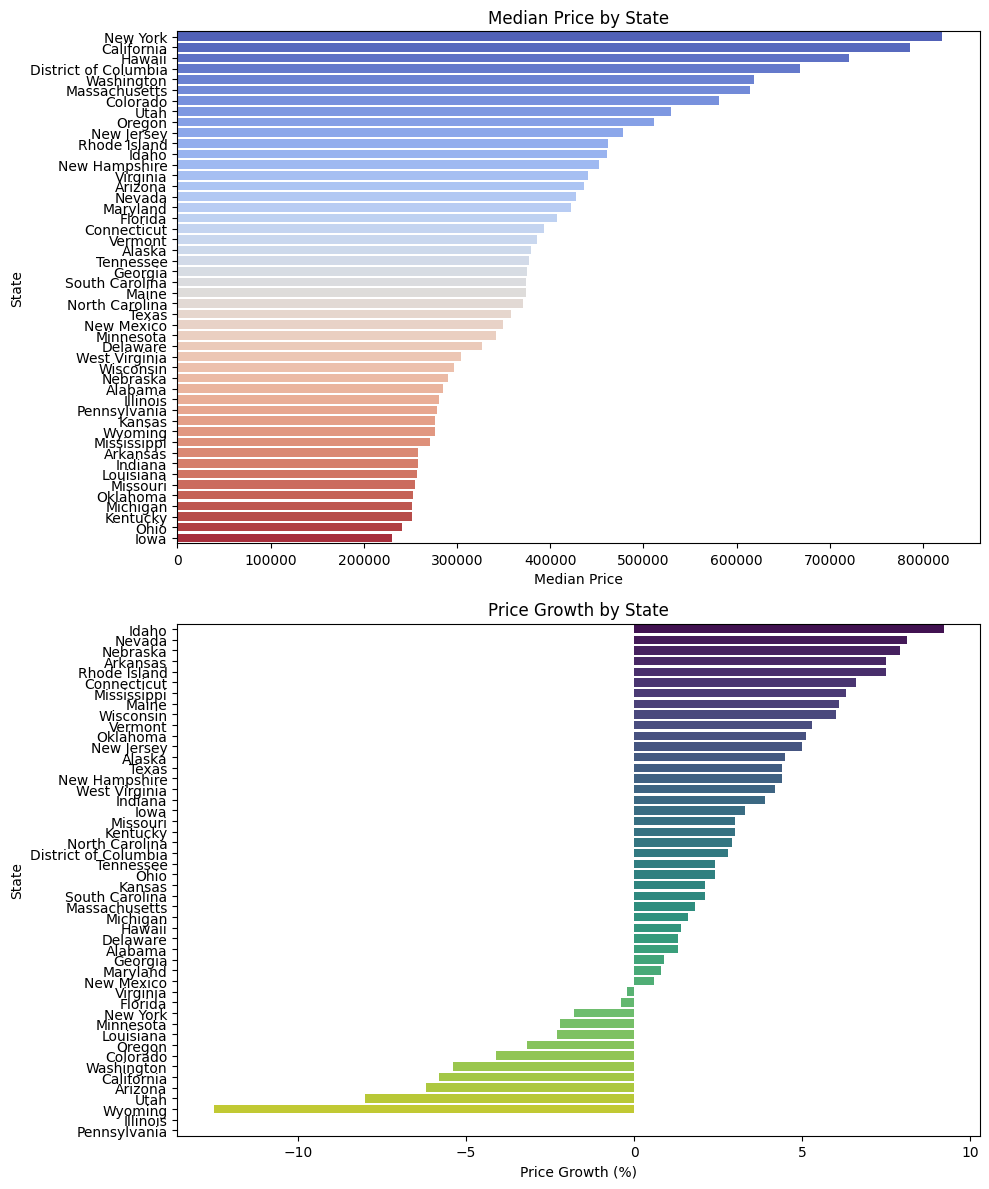

In [52]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Create a figure with two subplots (vertically arranged)
fig, ax = plt.subplots(2, 1, figsize=(10, 12))

# Bar plot for Median Price
sns.barplot(x='med_price', y='State', data=state_median_prices, palette='coolwarm', ax=ax[0])
ax[0].set_title('Median Price by State')
ax[0].set_xlabel('Median Price')
ax[0].set_ylabel('State')

# Bar plot for Price Growth
sorted_df_growth = state_median_prices.sort_values('price_growth', ascending=False).copy()

# Now, use the sorted dataframe for plotting
sns.barplot(x='price_growth', y='State', data=sorted_df_growth, palette='viridis', ax=ax[1])

ax[1].set_title('Price Growth by State')
ax[1].set_xlabel('Price Growth (%)')
ax[1].set_ylabel('State')


# Automatically adjust subplot params for a neat layout
plt.tight_layout()

# Display the combined figure
plt.show()

## Adding a New Dataset

In [53]:
poverty = pd.read_csv("ACSST5Y2020.S1701-Data.csv", usecols={'NAME','S1701_C03_001E','S1701_C03_002E'})

poverty = poverty.rename(columns={'S1701_C03_001E': 'total_below_pov', 'S1701_C03_002E': 'children_below_pov'})

poverty['NAME'] = poverty['NAME'].str.split(' ').str[1]

df_data = pd.merge(df_z,poverty, left_on = 'zcta', right_on = 'NAME', how = 'left')

df_data.head()

,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price,...,area_type,D3AAO,D1B,D5AR,TotEmp,Pct_AO0,walkability_bin,NAME,total_below_pov,children_below_pov
0,for_sale,3.00,2.00,0.12,Adjuntas,Puerto Rico,00601,920.00,NaN,105000.00,...,Rural,0.00,0.41,0.00,0.00,0.15,"(0.981, 2.883]",00601,64.4,72.1
1,for_sale,4.00,2.00,0.08,Adjuntas,Puerto Rico,00601,1527.00,NaN,80000.00,...,Rural,0.00,0.41,0.00,0.00,0.15,"(0.981, 2.883]",00601,64.4,72.1
2,for_sale,2.00,1.00,0.15,Juana Diaz,Puerto Rico,00795,748.00,NaN,67000.00,...,Rural,0.00,1.10,0.00,0.00,0.08,"(2.883, 4.767]",00795,45.7,55.3
3,for_sale,4.00,2.00,0.10,Ponce,Puerto Rico,00731,1800.00,NaN,145000.00,...,Rural,0.01,0.10,0.00,0.00,0.18,"(0.981, 2.883]",00731,53.6,69.3
4,for_sale,6.00,2.00,0.05,Mayaguez,Puerto Rico,00680,NaN,NaN,65000.00,...,Urban,0.00,6.04,0.00,0.00,0.32,"(6.65, 8.533]",00680,52.1,71.0


S1701_C03_001E

is percent below poverty line

S1701_C03_002E

is percent of children (below 18) below the poverty line

## Conclusion

In its current form this paper serves as an introduction into the correlation between house prices and walkability. Through the utilization of simple plots and maps this paper has outlined the positive, nearly linear relationship between National Walkability Index scores and house prices. These conclusions, along with the proven benefits of walkability, combine into a useful resource for policymakers and developers alike (Yencha, 2019). In reality, these simple plots are missing significant information that could assist in the creation of a truly comprehensive report. Information about more states, and full information without many ZCTAs missing would allow for a more accurate picture to be painted. 

Walkability remains an interesting variable when modeling house price, as consumers do not directly shop for a ‘walkable’ neighborhood. Instead consumers consider walkability in the back of their minds, and clearly, it has an impact on the value of a property. Measuring the exact amount that walkability affects real estate prices is a task too heavy for the tools available in this iteration of the project, but said prediction would be of immense benefit to real estate professionals and academics alike. Because of this, modeling of home price to walkability will continue, and this paper will serve to strengthen the already strong academic base in support of a correlation between walkability and home price. 

While this paper currently serves as an in depth introduction into the relationship between walkability and home price, adding further analysis will only strengthen this resource. Utilizing regressions will allow for a more in-depth analysis of the direct connection between walkability and home price, as well as creation of a hedonic model, able to represent the utility of a home based on its characteristics (Keskin, 2008).



### References:
Chapman, J., Fox, E.H., Bachman, W., Frank, L.D., Thomas, J., Reyes, A.R. (2021). Smart Location Database Technical Documentation And User Guide, Version 3.0.

Guo, Y., Peeta, S., & Somenahalli, S. (2017). The impact of walkable environment on single-family residential property values. Journal of Transport and Land Use, 10(1), 241-261.

Keskin, B. (2008). Hedonic analysis of price in the istanbul housing market. International Journal of Strategic Property Management, 12(2), 125-138. https://10.3846/1648-715X.2008.12.125-138

Kim, E. J., & Kim, H. (2020). Neighborhood walkability and housing prices: A correlation study. Sustainability, 12(2), 593.

Li, W., Joh, K., Lee, C., Jun-Hyun Kim, Park, H., & Woo, A. (2015). Assessing Benefits of Neighborhood Walkability to Single-Family Property Values. Journal of Planning Education and Research, 35(4), 471-488. https://10.1177/0739456X15591055

Pivo, G., & Fisher, J. D. (2011). The walkability premium in commercial real estate investments. Real Estate Economics, 39(2), 185-219.

Rauterkus, S. Y., & Miller, N. (2011). Residential land values and walkability. Journal of Sustainable Real Estate, 3(1), 23-43.

Yencha, C. (2019). Valuing walkability: New evidence from computer vision methods. Transportation Research.Part A, Policy and Practice, 130, 689-709. https://10.1016/j.tra.2019.09.053

